In [2]:
pip install --upgrade statsmodels

In [3]:
pip install --upgrade scipy

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
df = pd.read_csv('train.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df = df.sort_values('Order Date')

In [9]:
sales_ts = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum()
sales_ts.head()

/tmp/ipython-input-3344385002.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_ts = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum()


,Sales
Order Date,
2015-01-31,14205.707
2015-02-28,4519.892
2015-03-31,55205.797
2015-04-30,27906.855
2015-05-31,23644.303


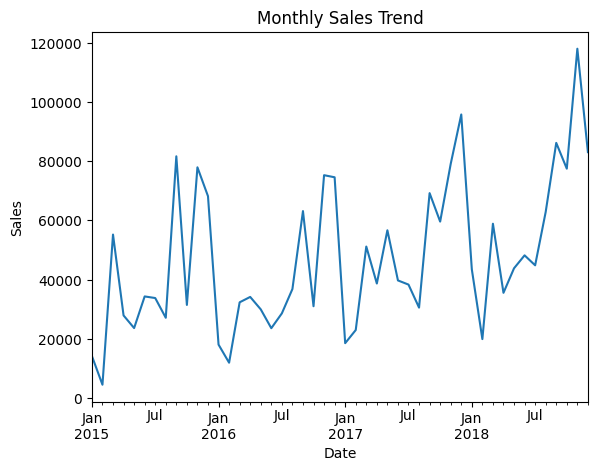

In [10]:
plt.figure()
sales_ts.plot()
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

<Figure size 640x480 with 0 Axes>

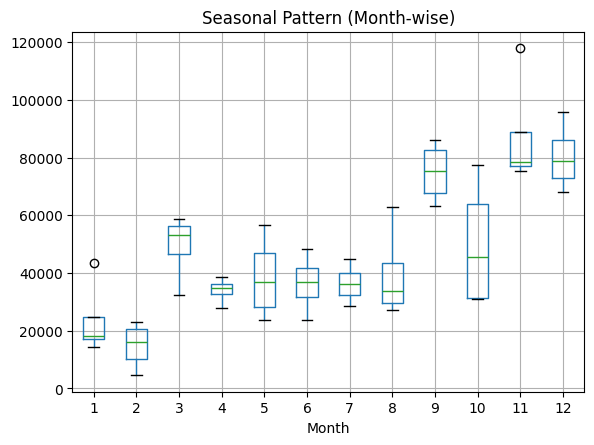

In [11]:
sales_ts_df = sales_ts.to_frame()
sales_ts_df['Month'] = sales_ts_df.index.month

plt.figure()
sales_ts_df.boxplot(column='Sales', by='Month')
plt.title("Seasonal Pattern (Month-wise)")
plt.suptitle("")
plt.show()

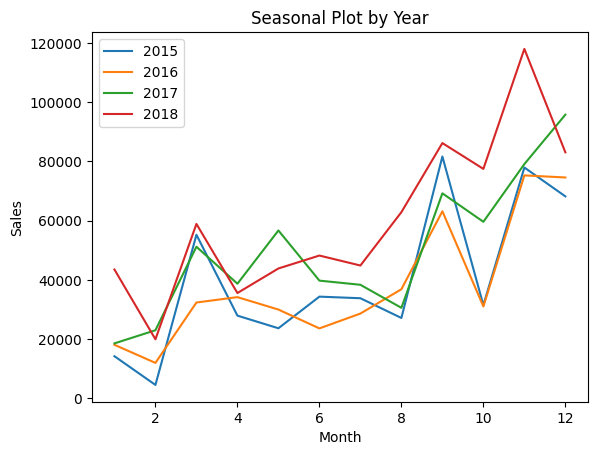

In [12]:
sales_ts_df['Year'] = sales_ts_df.index.year

plt.figure()
for year, group in sales_ts_df.groupby('Year'):
    plt.plot(group.index.month, group['Sales'], label=year)

plt.legend()
plt.title("Seasonal Plot by Year")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

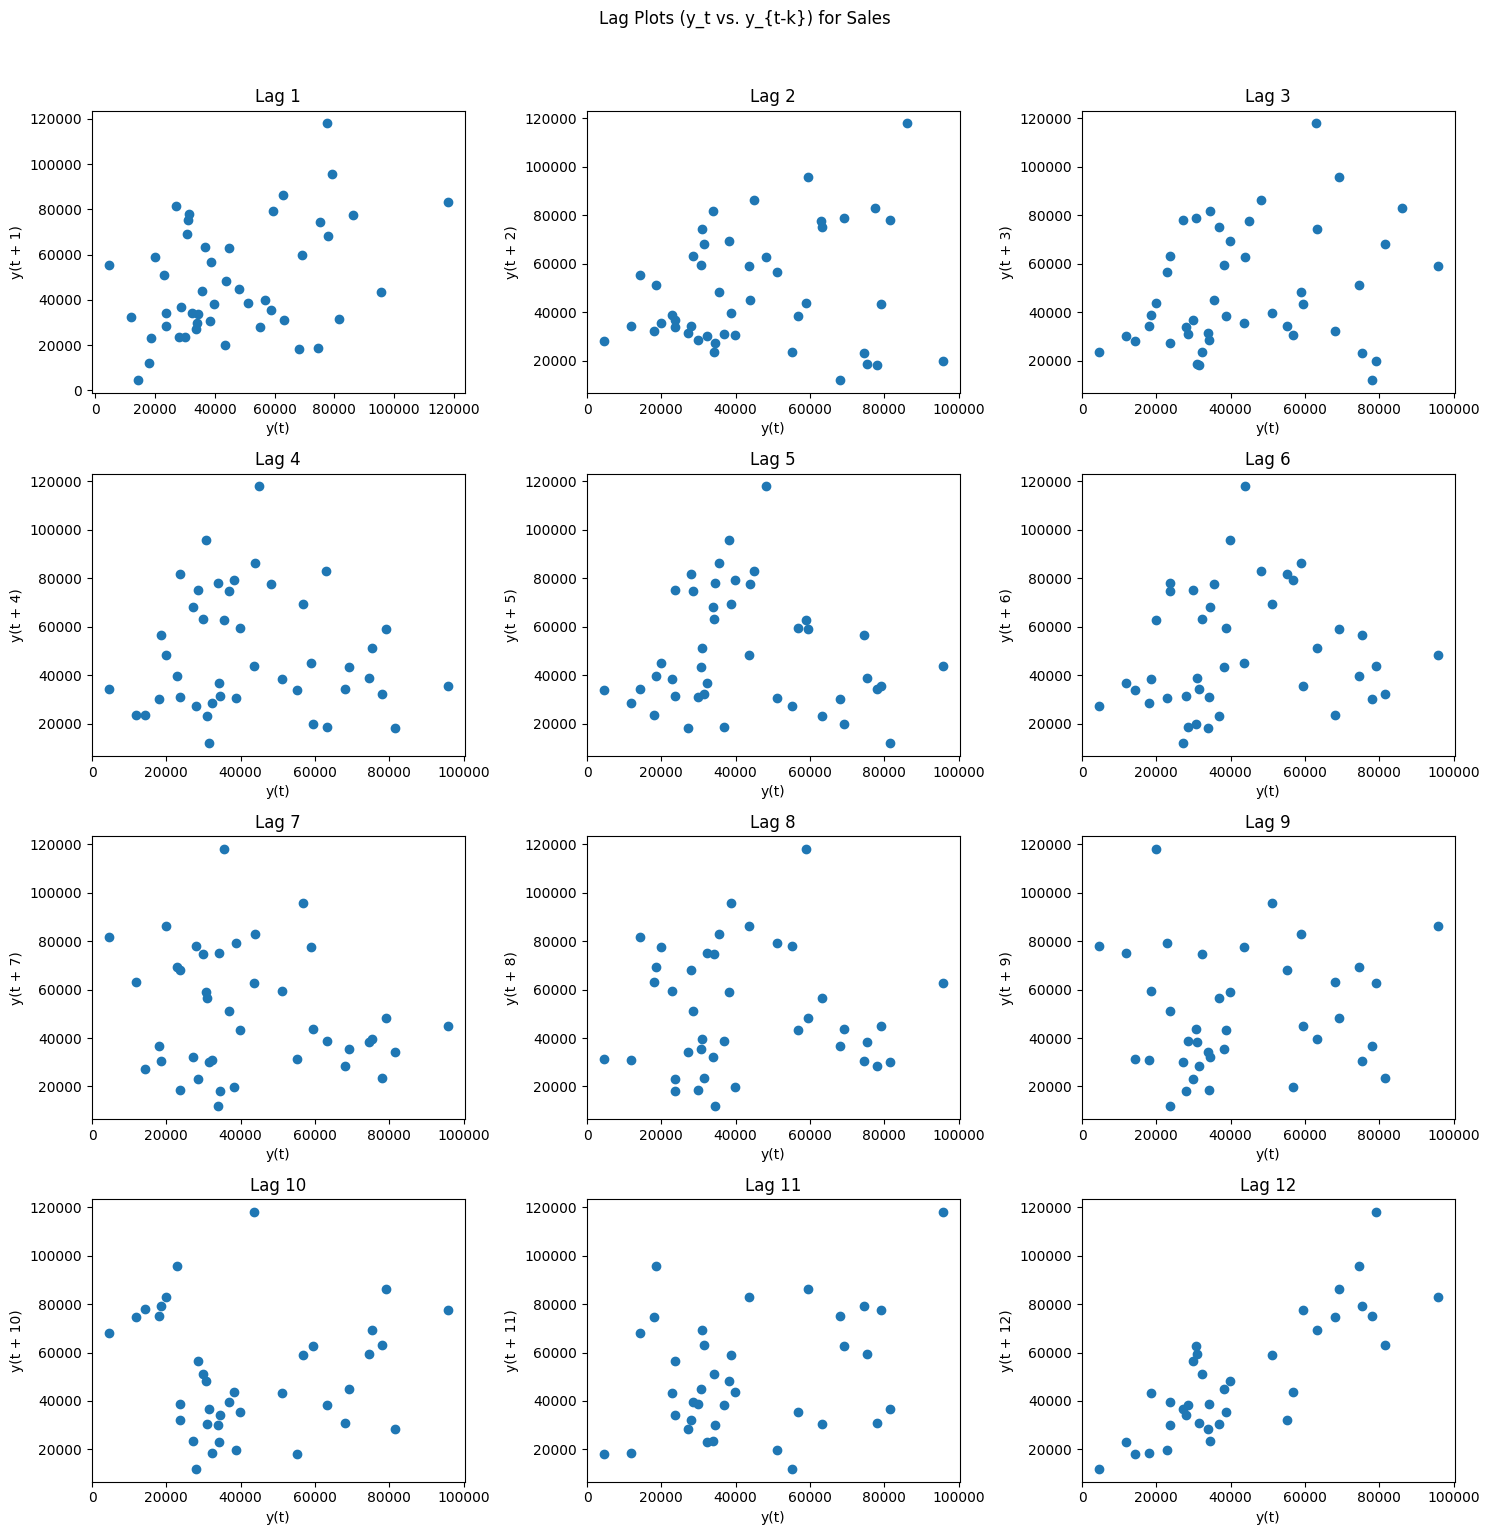

In [14]:
from pandas.plotting import lag_plot


fig, axes = plt.subplots(4, 3, figsize=(15, 15))
plt.suptitle('Lag Plots (y_t vs. y_{t-k}) for Sales', y=1.02)
axes = axes.flatten()


for i, lag in enumerate(range(1, 13)):
    ax = axes[i]
    lag_plot(sales_ts, lag=lag, ax=ax)
    ax.set_title(f'Lag {lag}')

plt.tight_layout()
plt.show()

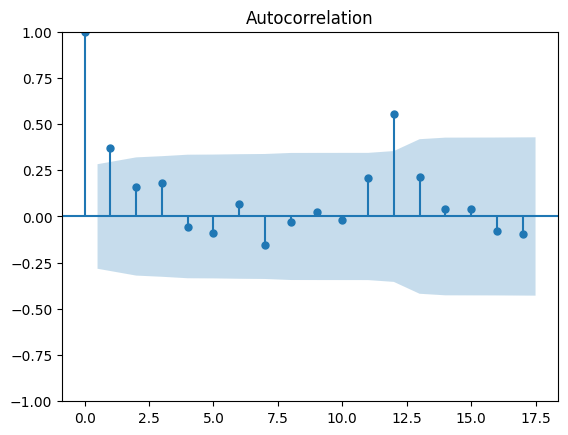

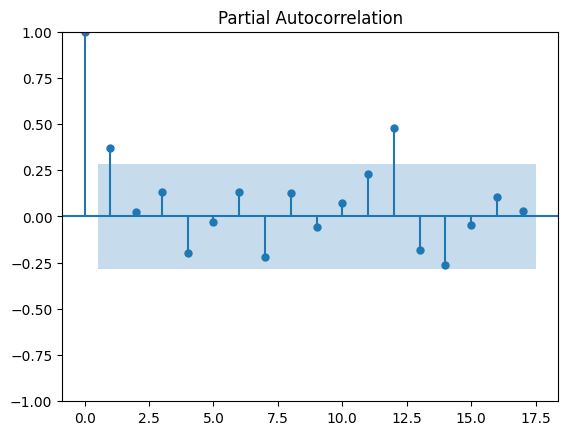

In [15]:
plot_acf(sales_ts)
plot_pacf(sales_ts)
plt.show()

In [16]:
sales_ts = sales_ts.asfreq('M')
sales_ts = sales_ts.interpolate(method='linear')

/tmp/ipython-input-3639683243.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_ts = sales_ts.asfreq('M')


/tmp/ipython-input-1669880636.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_sales = sales_ts.resample('Q').sum()


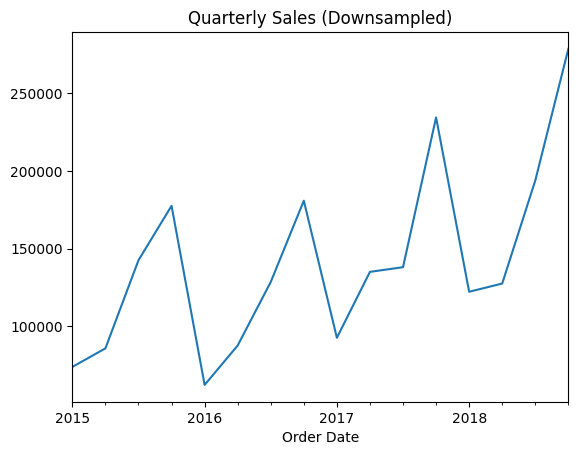

In [17]:
quarterly_sales = sales_ts.resample('Q').sum()

plt.figure()
quarterly_sales.plot()
plt.title("Quarterly Sales (Downsampled)")
plt.show()

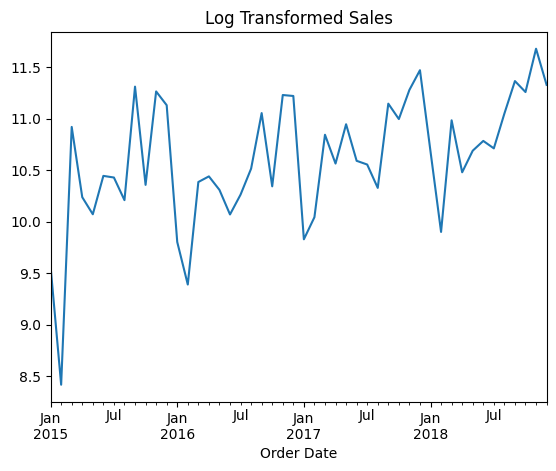

In [18]:
sales_log = np.log(sales_ts)

plt.figure()
sales_log.plot()
plt.title("Log Transformed Sales")
plt.show()

In [19]:
train = sales_log[:-12]
test = sales_log[-12:]

In [20]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

In [21]:
forecast = model_fit.forecast(steps=12)
forecast = np.exp(forecast)  # inverse log
test_actual = np.exp(test)

In [22]:
rmse = np.sqrt(mean_squared_error(test_actual, forecast))
mae = mean_absolute_error(test_actual, forecast)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 26520.58337488886
MAE: 21297.89162463097


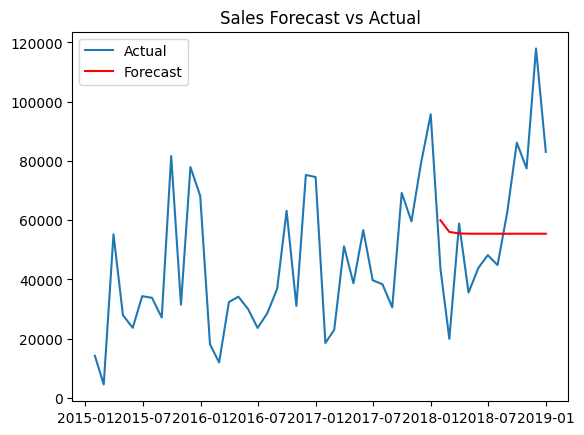

In [23]:
plt.figure()
plt.plot(sales_ts.index, sales_ts, label='Actual')
plt.plot(test_actual.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("Sales Forecast vs Actual")
plt.show()

Key Observations

Sales exhibit clear seasonality and upward trend

Monthly aggregation smoothens noise

Strong autocorrelation observed in lag plots

Log transformation stabilizes variance

Model Performance

ARIMA captures trend and seasonality effectively

RMSE and MAE indicate reasonable forecasting accuracy

Conclusion

Time series models like ARIMA are effective for sales forecasting when trend and seasonality are present. Proper preprocessing and visualization significantly improve model accuracy.